In [1]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2


In [2]:
from vicon.dereplication.derep import run_vsearch
from vicon.alignment.ref_align import run_viralmsa
from vicon.processing.sample_processing import process_all_samples
from vicon.visualization.plots import plot_non_gap_counts
from vicon.processing.coverage_analysis import abundant_kmers, crop_df, build_coverage_table, top_kmers_df, find_most_frequent_and_calculate_mismatches, get_i_th_kmers, select_best_kmers, count_seq_coverage, find_best_pair_kmer
from vicon.io.fasta import read_fasta_to_dataframe
from vicon.processing.sample_processing import pipeline_results_cleaner
from vicon.utils.helpers import count_non_gap_characters_from_dataframe, replace_hyphen_with_n
from vicon.visualization.plots import plot_rel_cons
from vicon.io.fasta import create_folders_and_save_sequences, read_fasta, remove_first_record, read_fasta_to_dataframe
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import shutil

In [3]:

import os

# Get the base path from the environment variable
base_path = os.getenv("PROJECTS_PATH")
base_path = f"{base_path}vicon/"
print(base_path)


/fast/AG_Ohler/ekarimi/projects/vicon/


In [4]:


VIRUS = "zikv_1993"
INPUT_SAMPLE = f"{base_path}data/zikv/zikv_1993/gisaid_ZIKV__1993.fasta"
INPUT_REFERENCE = f"{base_path}data/zikv/reference/RefSeq_ZIKV.fasta"

VIRALMSA_PATH = os.path.join(f"{base_path}scripts/ViralMSA.py")
OUTPUT_DIR = os.path.join(f"{base_path}results", VIRUS)

# Parameters for Tools
EMAIL = "email@address.com"
KMER_SIZE = 150
THRESHOLD = 140
L_GENE_START = -1
L_GENE_END = 21000

SAMPLE_DIR = os.path.dirname(INPUT_SAMPLE)
REFERENCE_DIR = os.path.dirname(INPUT_REFERENCE)

LOG_DIR = os.path.join(OUTPUT_DIR, "logs")
MAIN_DF_PATH = os.path.join(OUTPUT_DIR, "aggregated_results.csv")
KMER1_PATH = os.path.join(OUTPUT_DIR, "kmer1.csv")
KMER2_PATH = os.path.join(OUTPUT_DIR, "kmer2.csv")

# File Names
SAMPLE_NAME = os.path.basename(INPUT_SAMPLE)
REFERENCE_NAME = os.path.basename(INPUT_REFERENCE)

# Paths
DEREP_FASTA = os.path.join(SAMPLE_DIR, "derep.fasta")
CLUSTERS_UC = os.path.join(SAMPLE_DIR, "clusters.uc")
ALIGNED_DIR = os.path.join(SAMPLE_DIR, "aligned")
if os.path.exists(ALIGNED_DIR):
    shutil.rmtree(ALIGNED_DIR)
DEREP_FASTA_ALN = os.path.join(ALIGNED_DIR, "derep.fasta.aln")


# Example Usage of Paths and Functions
replace_hyphen_with_n(INPUT_SAMPLE, INPUT_SAMPLE)

run_vsearch(INPUT_SAMPLE, DEREP_FASTA, CLUSTERS_UC)

run_viralmsa(
    email=EMAIL, 
    sample_fasta=DEREP_FASTA, 
    output_dir=ALIGNED_DIR, 
    reference_fasta=INPUT_REFERENCE, 
    script_path=VIRALMSA_PATH
)

remove_first_record(DEREP_FASTA_ALN, DEREP_FASTA_ALN)

# Process all samples and aggregate results
df, mask = process_all_samples(INPUT_REFERENCE, DEREP_FASTA_ALN, LOG_DIR, window_size=KMER_SIZE, threshold=THRESHOLD, only_valid_kmers=True)
df3, mask3 = process_all_samples(INPUT_REFERENCE, DEREP_FASTA_ALN, LOG_DIR, window_size=KMER_SIZE, threshold=KMER_SIZE-3, only_valid_kmers=True)

# Save aggregated results
# df.to_csv(MAIN_DF_PATH)
# print("Aggregated results saved.")

# df = pd.read_csv(MAIN_DF_PATH, index_col="SampleID")
df


An error occurred: [Errno 2] No such file or directory: '/fast/AG_Ohler/ekarimi/projects/vicon/data/zikv/zikv_1993/gisaid_ZIKV__1993.fasta'
vsearch v2.29.1_linux_x86_64, 1509.9GB RAM, 80 cores
https://github.com/torognes/vsearch



Fatal error: Unable to open file for reading (/fast/AG_Ohler/ekarimi/projects/vicon/data/zikv/zikv_1993/gisaid_ZIKV__1993.fasta)


RuntimeError: Vsearch failed with return code 1.

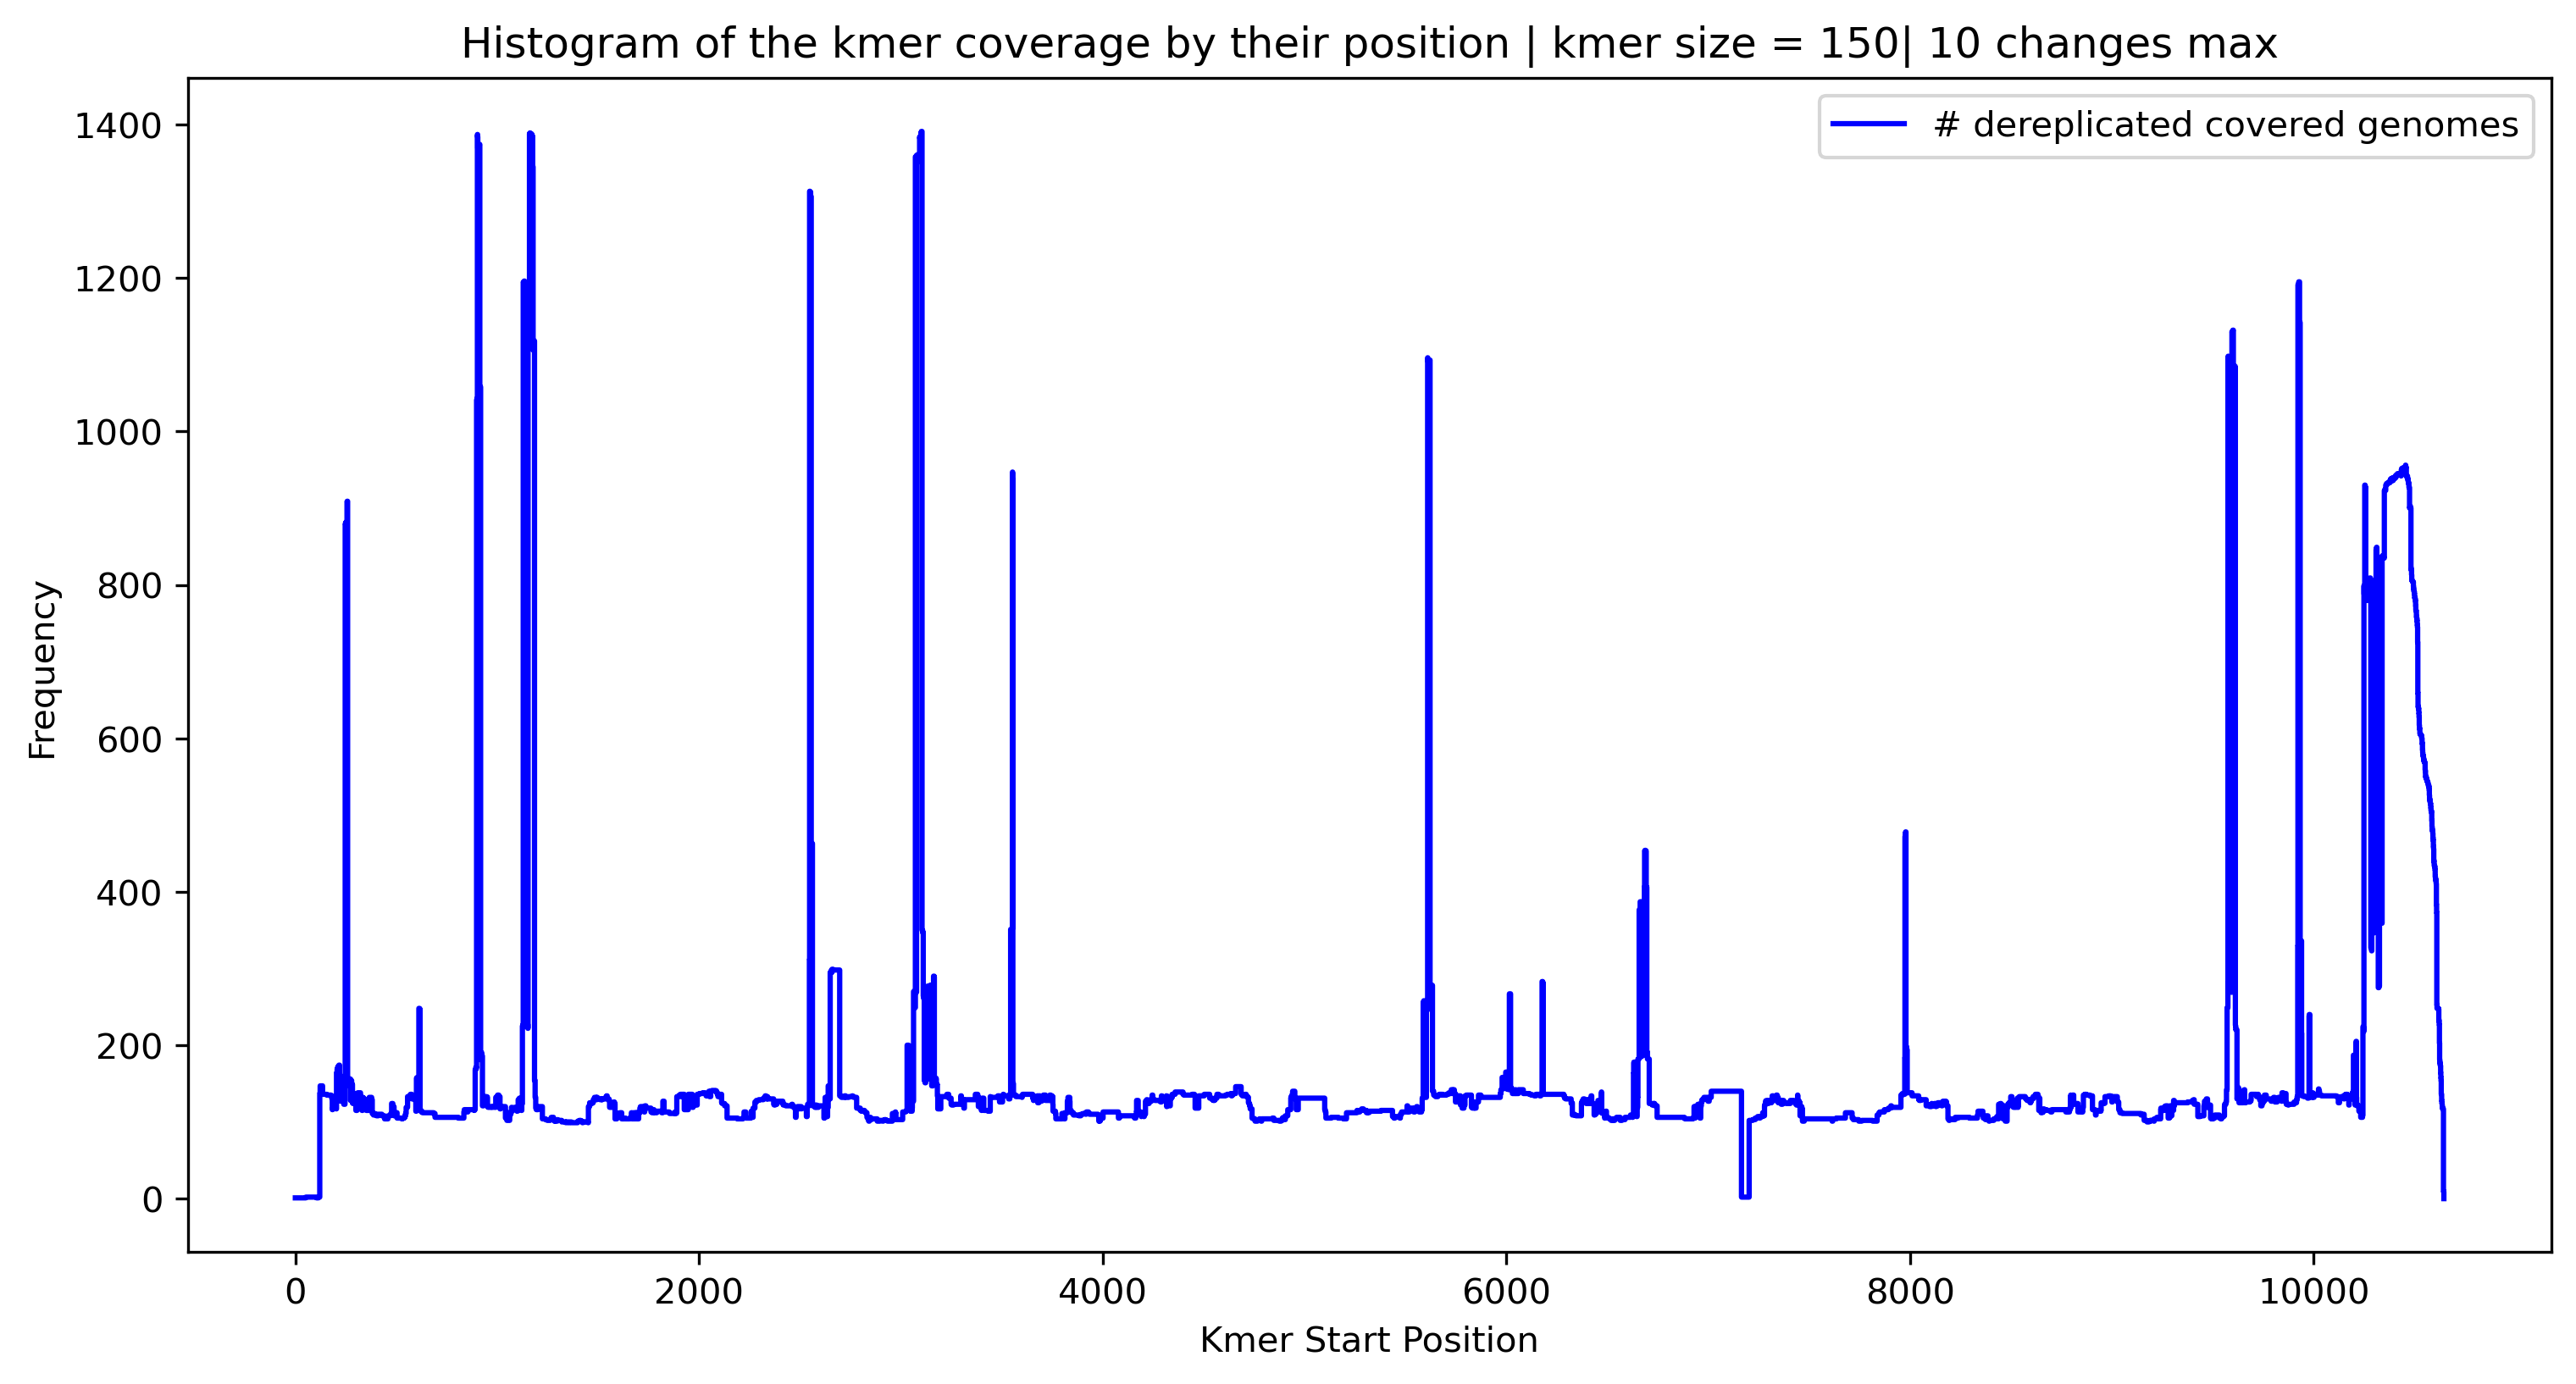

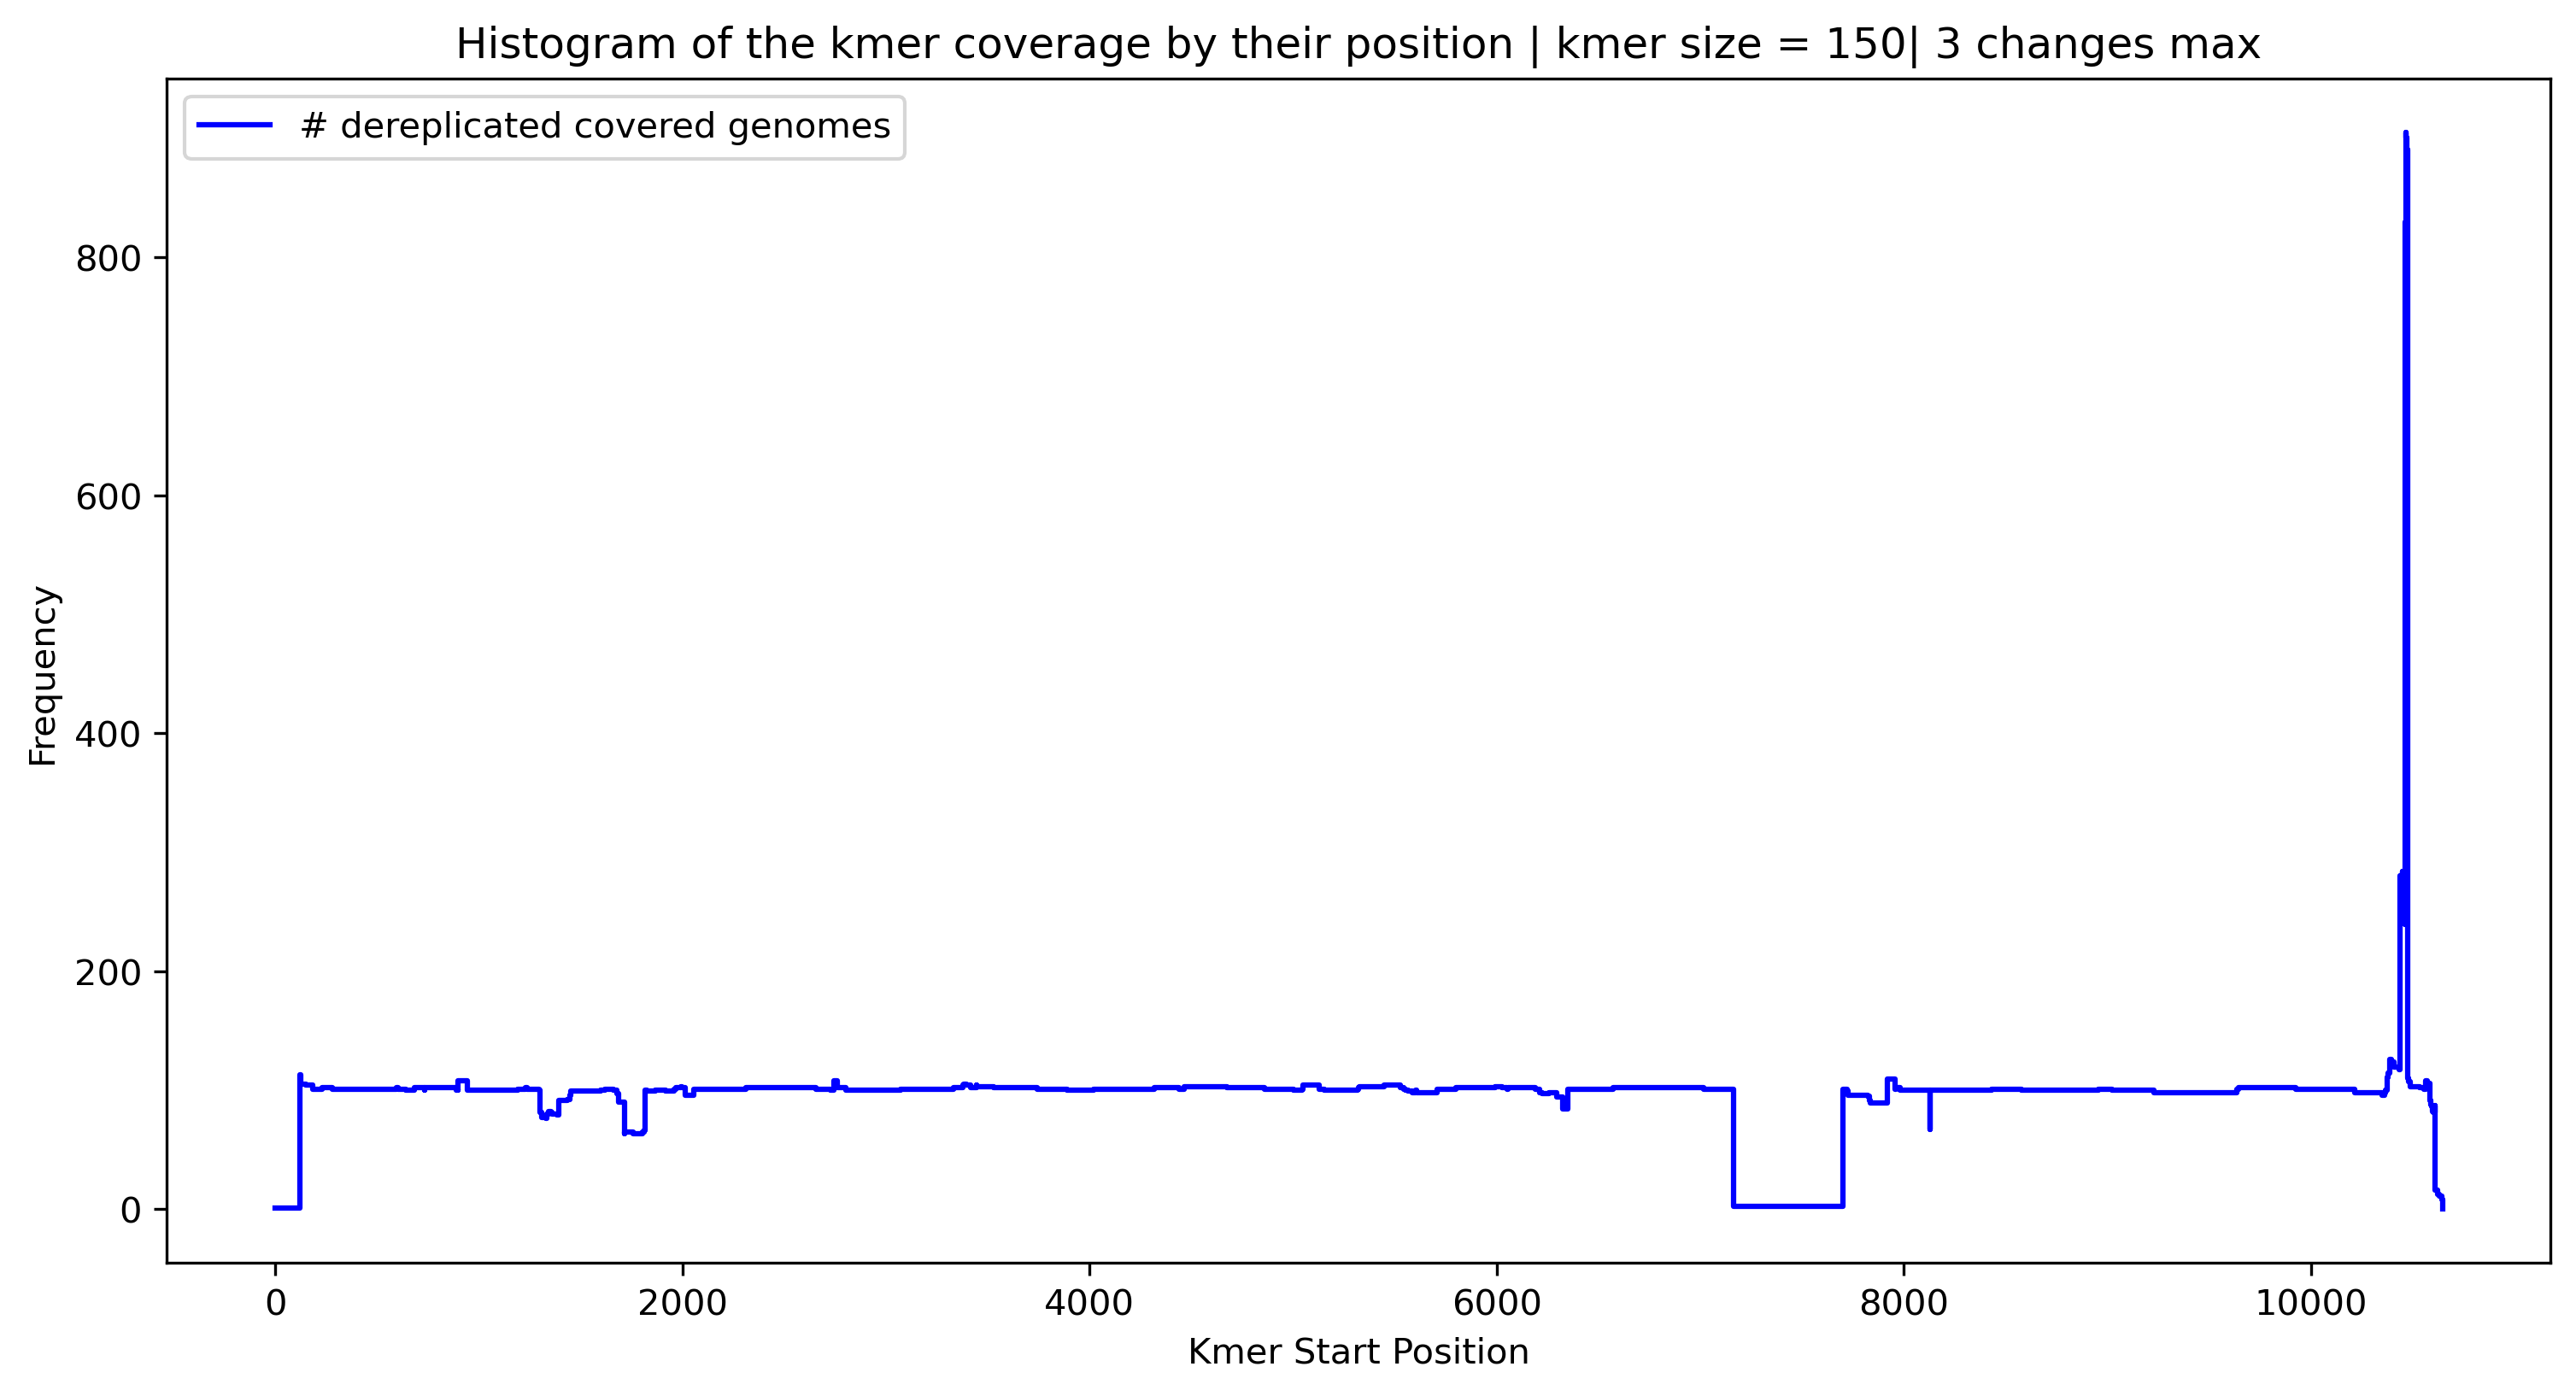

In [6]:
df.columns = df.columns.astype(int)
plot_rel_cons(df,kmer_size=KMER_SIZE, threshold=KMER_SIZE-THRESHOLD)
plot_rel_cons(df3, kmer_size=KMER_SIZE, threshold=3)


In [7]:
# This should be defined based on the plots you get
COVERAGE_RATIO = 800/ df.shape[0]

# Crop DataFrame to L gene region and apply coverage threshold
ldf = crop_df(df, L_GENE_START, L_GENE_END, coverage_ratio=COVERAGE_RATIO)
kmer1, kmer2 = find_best_pair_kmer(ldf, DEREP_FASTA_ALN, mask, window_size=150)

Limiting DataFrame to gene region from position -1 to 21000
Minimum coverage threshold set to 800 based on coverage ratio 0.4744958481613286
DataFrame cropped to 310 columns with coverage above threshold.
Max coverage with 2 kmers: 0.9092526690391459


In [10]:
df_ref = read_fasta_to_dataframe(INPUT_REFERENCE)
ref_seq = df_ref['Sequence'].values[0]

# Extract kmer sequences
kmer1_seq = ref_seq[kmer1:kmer1+KMER_SIZE]
kmer2_seq = ref_seq[kmer2:kmer2+KMER_SIZE]

print(f"Kmer1 sequence (position {kmer1}):\n{kmer1_seq}")
print(f"Kmer2 sequence (position {kmer2}):\n{kmer2_seq}")




df_kmers1, df_kmers2 = pipeline_results_cleaner(sample_address=DEREP_FASTA_ALN,
                                                kmer1=kmer1,
                                                kmer2=kmer2,
                                                drop_old_samples=False,
                                                kmer_size= 150,
                                                min_year=2020,
                                                threshold_ratio=0.01,
                                                drop_mischar_samples=True
                                                # drop_mutants=False
                                               )


df_kmers1.to_csv(KMER1_PATH)
df_kmers2.to_csv(KMER2_PATH)


df_counts = count_non_gap_characters_from_dataframe(df_kmers1, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VIRUS}**kmers1 -- Non-Gap Character Counts at Each Position',
                    save = os.path.join(OUTPUT_DIR, "kmers1_mutations.png"))

df_counts = count_non_gap_characters_from_dataframe(df_kmers2, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VIRUS}**kmers2 -- Non-Gap Character Counts at Each Position',
                    save = os.path.join(OUTPUT_DIR, "kmers2_mutations.png"))

Kmer1 sequence (position 3076):
TGGATTGAAAGTGAAAAGAATGACACATGGAGGCTGAAGAGGGCCCACCTGATTGAGATGAAAACATGTGAATGGCCAAAGTCTCACACATTGTGGACAGATGGAGTAGAAGAAAGTGATCTTATCATACCCAAGTCTTTAGCTGGTCCA
Kmer2 sequence (position 10464):
ATAGTCAGGCCGAGAACGCCATGGCACGGAAGAAGCCATGCTGCCTGTGAGCCCCTCAGAGGACACTGAGTCAAAAAACCCCACGCGCTTGGAAGCGCAGGATGGGAAAAGAAGGTGGCGACCTTCCCCACCCTTCAATCTGGGGCCTGA
Read 1686 samples from /fast/AG_Ohler/ekarimi/projects/vicon/data/zikv/zikv_1993/aligned/derep.fasta.aln.
df_samples shape before dropping NaN years: (1686, 5)
df_samples shape after dropping NaN years: (1617, 5)
df_samples shape after dropping samples with non ATCG chars: (863, 5)
Plot saved as /fast/AG_Ohler/ekarimi/projects/vicon/results/zikv_1993/kmers1_mutations.png
Plot saved as /fast/AG_Ohler/ekarimi/projects/vicon/results/zikv_1993/kmers2_mutations.png
